In [1]:
from util import d, here, tic, toc
from NSynthDataSet_RawAudio import NSynthDataSet_RawAudio
from transformers import GTransformer

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import RandomSampler

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from librosa.display import specshow
import pandas as pd

from argparse import ArgumentParser

import random, sys, math, gzip, os
import json
from tqdm import tqdm
from IPython.display import Audio 
import IPython
import soundfile 
import copy
import datetime

%load_ext autoreload
%autoreload 2

In [2]:
# Data location
data_dir = '/home/purnima/appdir/Github/DATA/nsynth.64.76.dl/'

### Constants 
sample_rate = 16000
batch_size = 16
lr = 0.0001
lr_warmup = 10000
epochs = 1000

sample_length = 512 # For context
embedding_size = 128 
num_heads = 8 # Number of chunks for 'parallel/ensemble' computation
depth = 12 # Number of transformer layers
num_tokens = 256 #Size of the dictionary

lower_pitch_limit = 64
upper_pitch_limit = 76

In [3]:
model = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=sample_length, num_tokens=num_tokens, attention_type=None)
model = model.cuda()

opt = torch.optim.Adam(lr=lr, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (lr_warmup / batch_size), 1.0))
loss = torch.nn.NLLLoss(reduction='mean')

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

2474496

In [5]:
print(model)
# model.token_embedding.register_forward_hook(lambda m, input, output: print(output))

GTransformer(
  (token_embedding): Linear(in_features=4, out_features=128, bias=True)
  (token_embedding_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (token_embedding_activation): ReLU()
  (pos_embedding): Linear(in_features=512, out_features=128, bias=True)
  (pos_embedding_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (pos_embedding_activation): ReLU()
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=128, out_features=128, bias=False)
        (toqueries): Linear(in_features=128, out_features=128, bias=False)
        (tovalues): Linear(in_features=128, out_features=128, bias=False)
        (unifyheads): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Se

## Sampling
Sampling is done as follows -  
1. Select an input from the dataloader (update sample_index to any value from 0 to 15). Shape will be `1 X sample_length` or `1 X 512`
2. Generate the output from the model. Shape will be `1 X 512 X 256`
3. Retrieve the last sample from the 512 sample_length dimension `sample_data = sample_data[0, -1, :]` (argmax or temperature sampling (-- I need to understand this more--)  
4. Append this sample to the input (from step 1). Both input and this new sample are between 0 - 255. Use this as the new input and repeat from Step 1 for as long as you want (here we are iterating through the steps 256 times to generate 256 new samples).
5. Convert this 512 + 256 new samples to waveform using mu_expand from librosa.

In [6]:
def load_model(model, opt, model_location):
    checkpoint = torch.load(model_location)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    return model, opt, loss, epoch

def mulawEncodeInput(inputd):
    inputd = (librosa.mu_compress(inputd, quantize=False) + 1)/2
    return inputd

def mulawDecodeInput(output):
    output = (output * 2) - 1
    waveform = librosa.mu_expand(output, quantize=False)
    return waveform

def mulawEncodeTarget(inputd):
    target = librosa.mu_compress(inputd, quantize=True) + 127
    target = target.astype(np.long)
    return target

def mulawDecodeTarget(output):
    output = output - 127
    waveform = librosa.mu_expand(output, quantize=True)
    return waveform

def get_scaled_pitch(pitch):
    return (pitch - lower_pitch_limit)/(upper_pitch_limit - lower_pitch_limit)

In [7]:
def get_data(idx, start_location):
    start_location = int(start_location * 16000)
    
    audio_file_name = os.path.join(data_dir, idx+'.wav')
    audio_data, _ = librosa.load(audio_file_name, sr=sample_rate)
    input_data = audio_data[start_location:start_location + sample_length]

    IPython.display.display(IPython.display.Audio(audio_data, rate=sample_rate))
    
    fig, axes = plt.subplots(ncols=2, figsize=(8,4))
    axes[0].plot(audio_data)
    axes[0].set(title='Sample Length = 64000/4 secs')
    axes[1].plot(input_data)
    axes[1].set(title='Sample Length = 512/32 ms')
    
    target = audio_data[start_location + 1:start_location + 1 + sample_length]
    
    return input_data, target


In [8]:
def sample_model(seed_id, model, start_location=1.0, pitch=64, amplitude_scale=0.9, instrument_id=0, seq_len=1024):
    start_time = datetime.datetime.now().replace(microsecond=0)
    
    seed, seed_target = get_data(seed_id, start_location)
    
    final_waveform = copy.copy(seed) 
    
    orig_input_data = mulawEncodeInput(copy.copy(seed))
    pitch = np.broadcast_to(np.array([get_scaled_pitch(pitch)]), orig_input_data.shape)
    scale = np.broadcast_to(np.array([amplitude_scale]), orig_input_data.shape)
    instrument = np.broadcast_to(np.array([instrument_id]), orig_input_data.shape)
    input_data = np.stack((orig_input_data, pitch, scale, instrument ), axis=0)
    input_data = torch.from_numpy(input_data).cuda()
    
    model.eval()
    
    with torch.no_grad():
        for ind in range(seq_len):
            input_data = input_data.view(1, -1, 4).float()
            sample_data = model(input_data) 
            sample_data = sample_data[0, -1, :].argmax()
            sample_data = mulawDecodeTarget(sample_data.view(1,-1).cpu().numpy())
            
            final_waveform = np.append(final_waveform, sample_data)
            
            sample_input = mulawEncodeInput(sample_data)
            orig_input_data = np.append(orig_input_data, sample_input)
            
            input_data = orig_input_data[orig_input_data.shape[0]-sample_length:]
            input_data = np.stack((input_data, pitch, scale, instrument ), axis=0)
            input_data = torch.from_numpy(input_data).cuda()
            
    
    # 2. Audio
    IPython.display.display(IPython.display.Audio(seed, rate=sample_rate))
    IPython.display.display(IPython.display.Audio(final_waveform, rate=sample_rate))
    
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    axes[0].plot(seed)
    axes[0].set_title('Original Seed')

    axes[1].plot(final_waveform)
    axes[1].set_title('New Sample')
    
    plt.show()
    
    # 3. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    
    D = librosa.stft(seed)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[0])
    axes[0].set(title='Orig seed')
    fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(final_waveform)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[1])
    axes[1].set(title='New Sample')
    fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    print('Time taken for sampling/plotting = ', datetime.datetime.now().replace(microsecond=0) - start_time)

    return final_waveform, seed

In [9]:
# 7.20pm Reed+Brass all instruments run - where input is not multiplied with ampl_scale
model, opt, loss, epoch = load_model(model, opt, 'checkpoint/attention-45460.pt')
print('Model Loaded')

Model Loaded


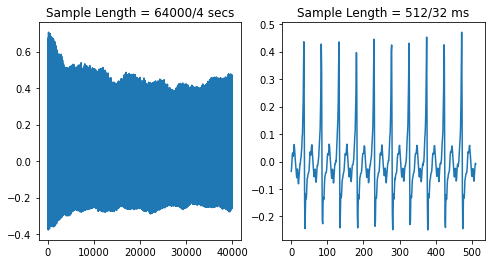

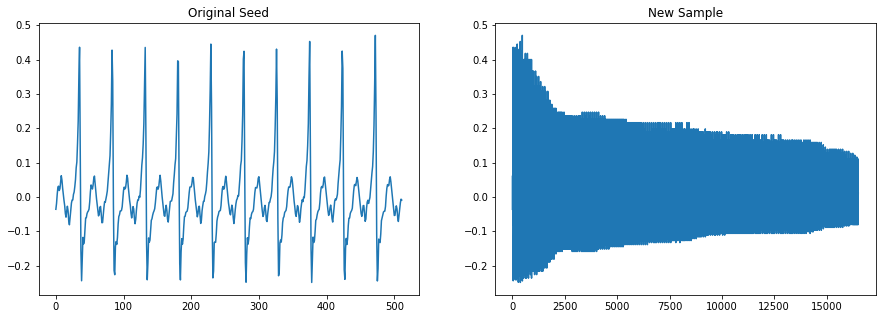

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


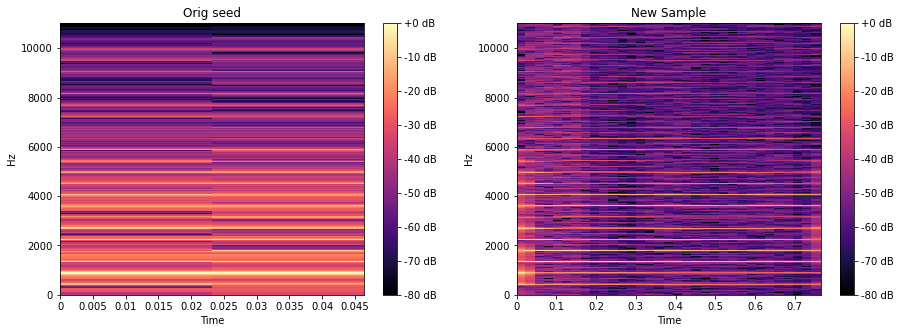

Time taken for sampling/plotting =  0:03:33


In [36]:
new_sample, orig_seed = sample_model('brass_acoustic_018-064-a.90', model=model, start_location=1, pitch=64, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

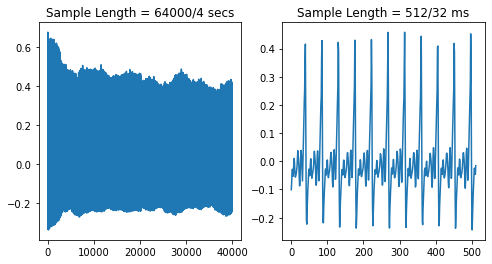

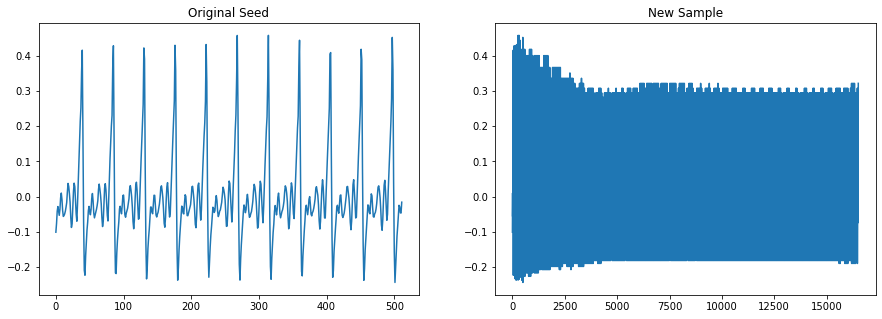

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


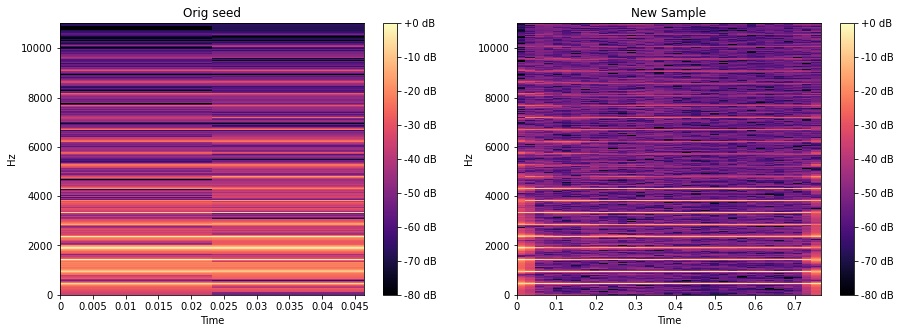

Time taken for sampling/plotting =  0:03:32


In [37]:
new_sample, orig_seed = sample_model('brass_acoustic_018-065-a.90', model=model, start_location=1, pitch=65, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

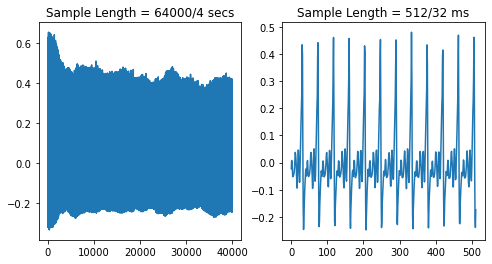

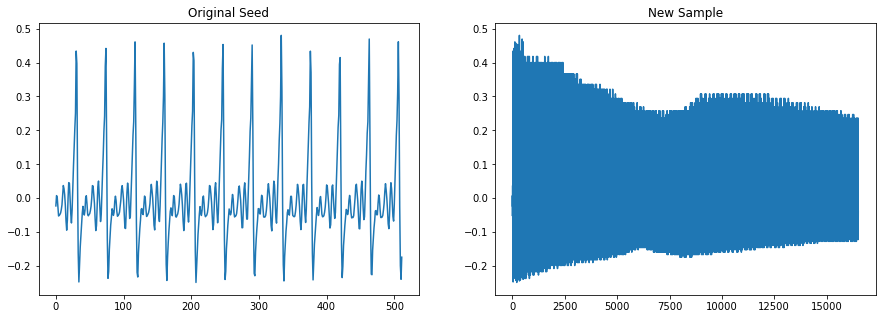

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


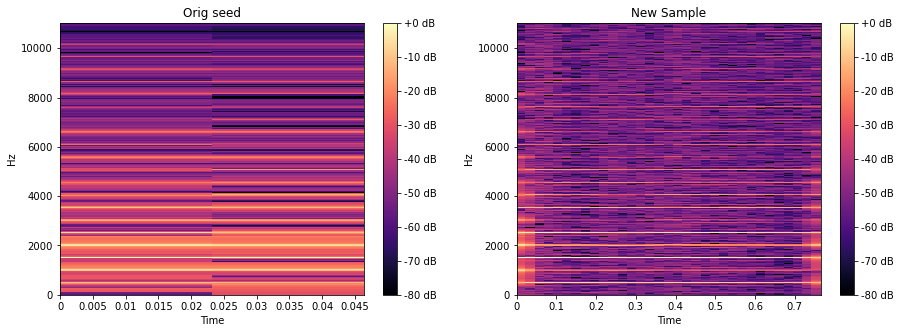

Time taken for sampling/plotting =  0:03:32


In [38]:
new_sample, orig_seed = sample_model('brass_acoustic_018-066-a.90', model=model, start_location=1, pitch=66, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

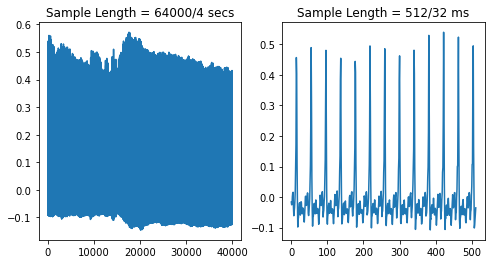

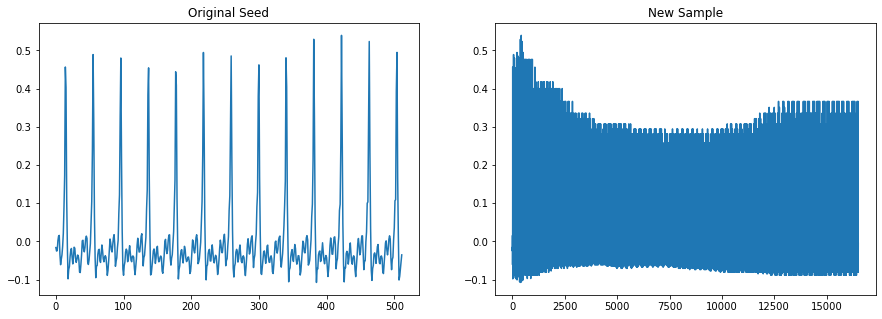

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


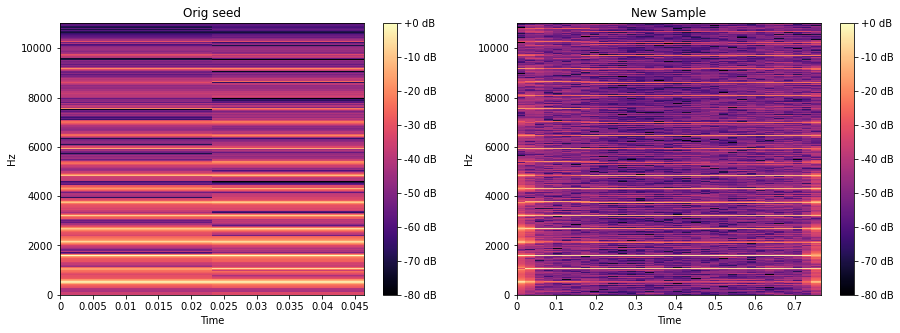

Time taken for sampling/plotting =  0:03:28


In [39]:
new_sample, orig_seed = sample_model('brass_acoustic_018-067-a.90', model=model, start_location=1, pitch=67, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

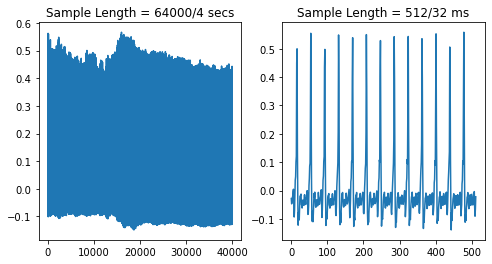

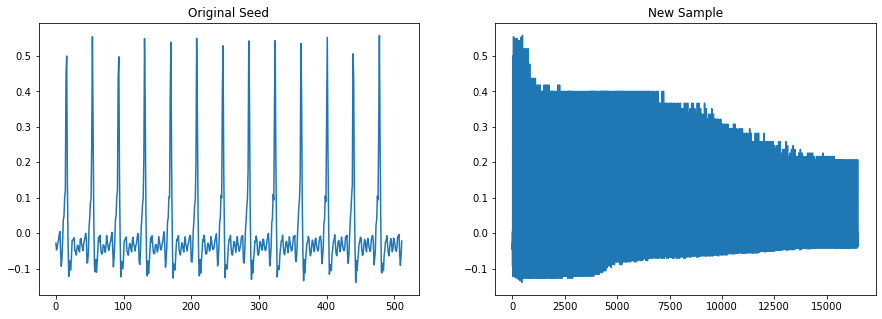

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


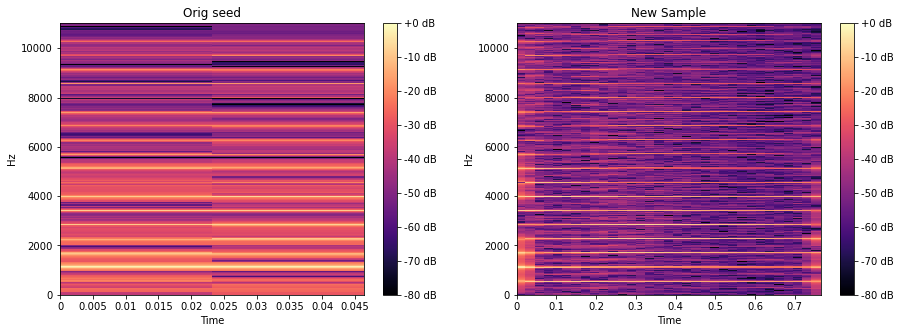

Time taken for sampling/plotting =  0:03:34


In [40]:
new_sample, orig_seed = sample_model('brass_acoustic_018-068-a.90', model=model, start_location=1, pitch=68, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

In [ ]:
new_sample, orig_seed = sample_model('brass_acoustic_018-069-a.90', model=model, start_location=0.25, pitch=69, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

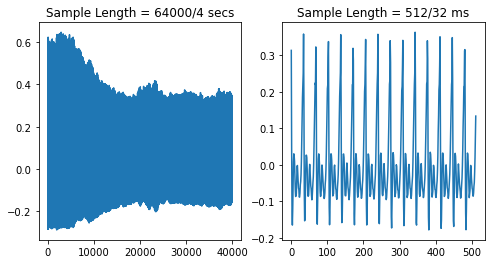

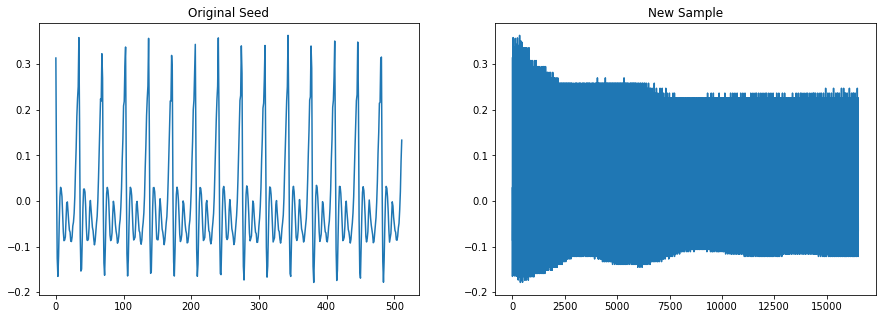

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


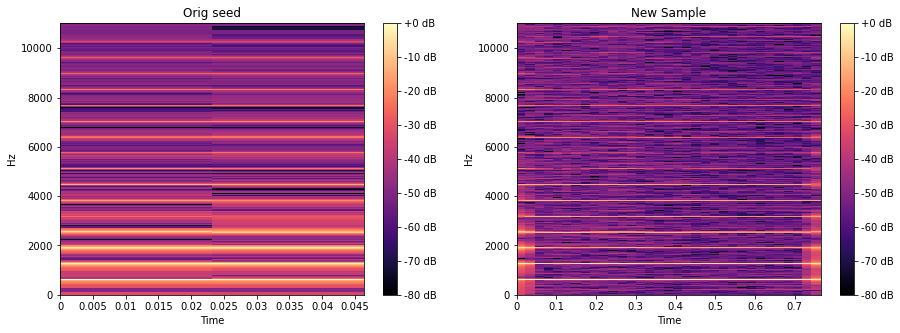

Time taken for sampling/plotting =  0:03:33


In [42]:
new_sample, orig_seed = sample_model('brass_acoustic_018-070-a.90', model=model, start_location=1, pitch=70, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

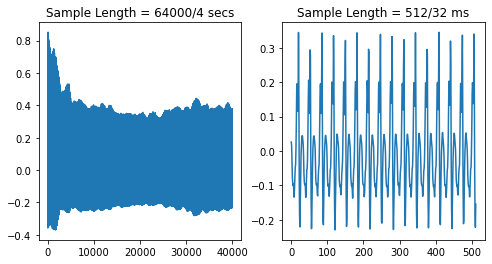

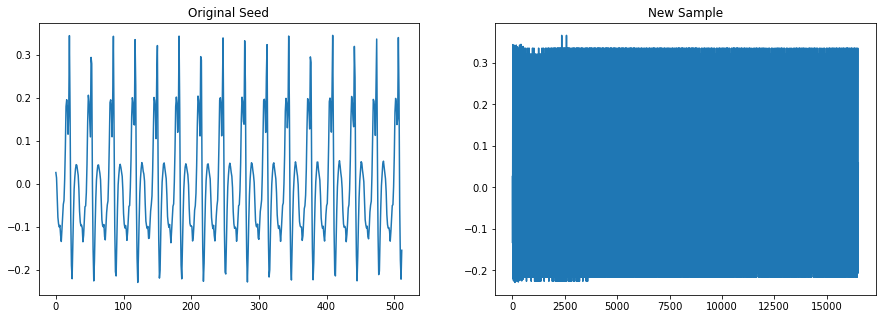

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


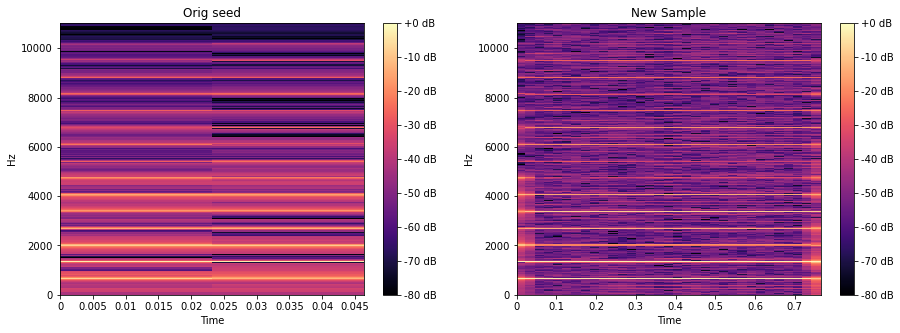

Time taken for sampling/plotting =  0:03:36


In [43]:
new_sample, orig_seed = sample_model('brass_acoustic_018-071-a.90', model=model, start_location=1, pitch=71, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

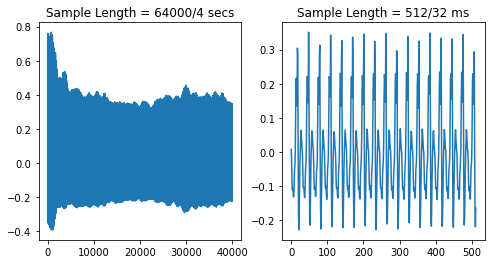

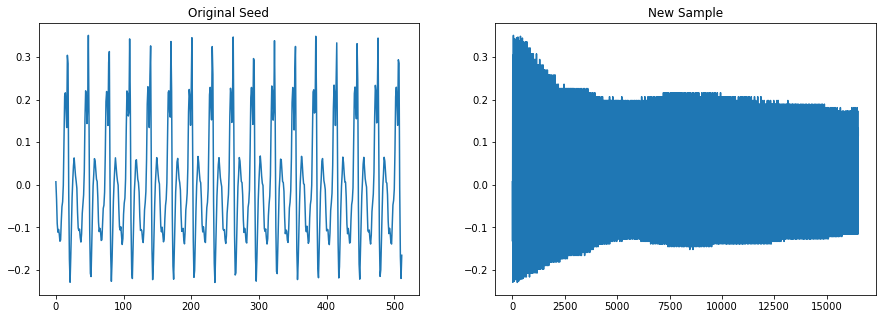

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


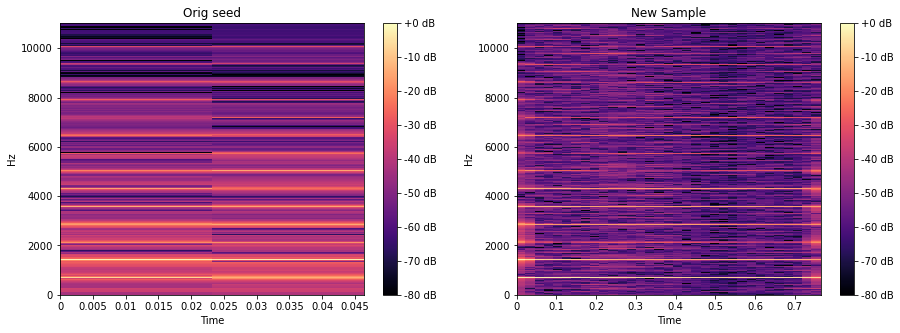

Time taken for sampling/plotting =  0:03:43


In [44]:
new_sample, orig_seed = sample_model('brass_acoustic_018-072-a.90', model=model, start_location=1, pitch=72, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

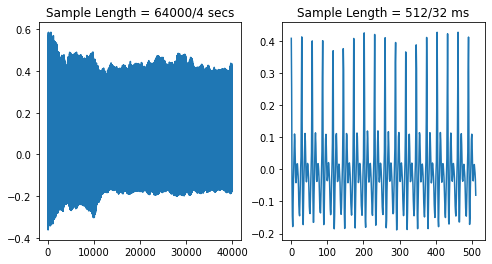

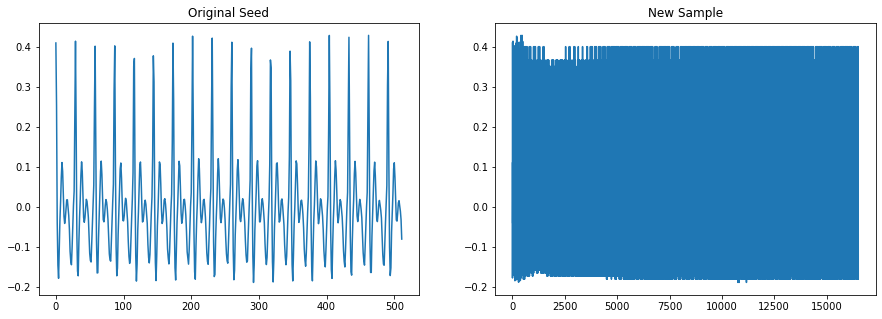

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


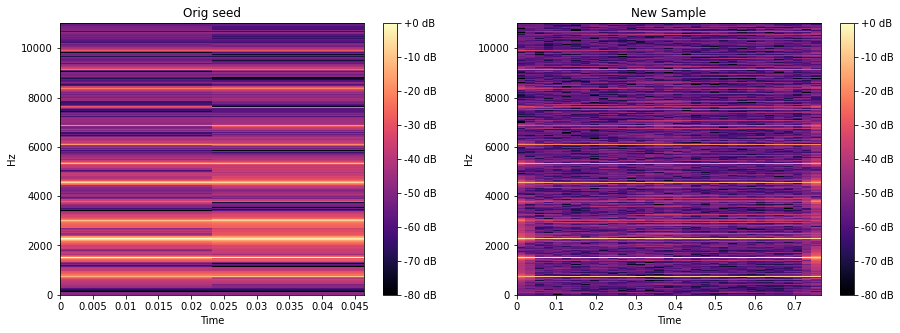

Time taken for sampling/plotting =  0:03:46


In [45]:
new_sample, orig_seed = sample_model('brass_acoustic_018-073-a.90', model=model, start_location=1, pitch=73, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

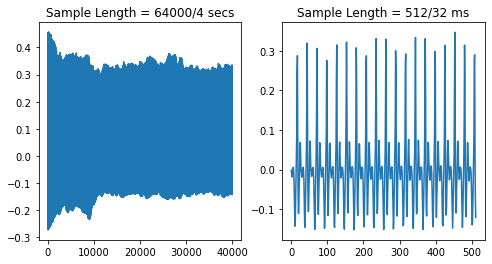

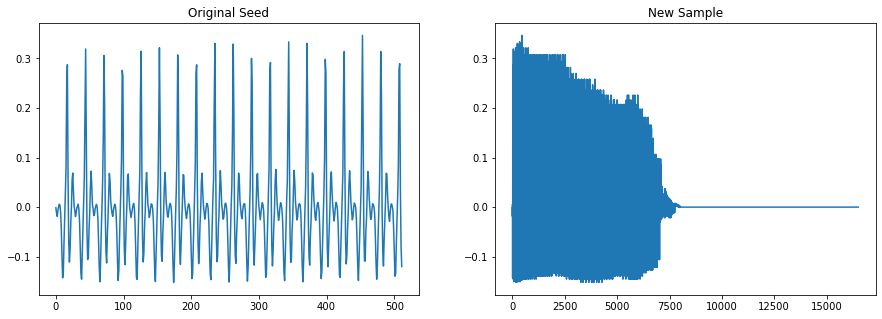

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


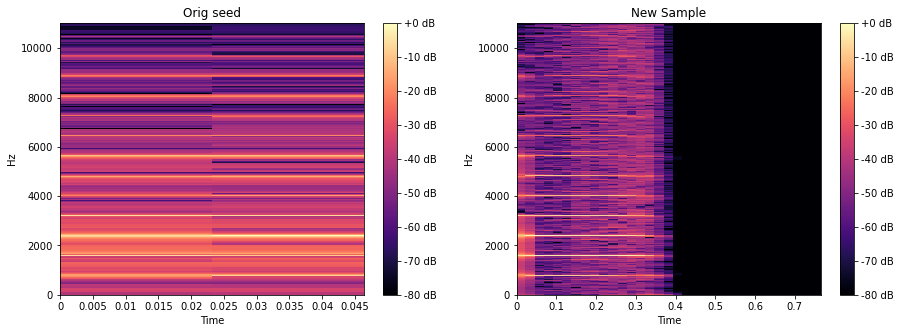

Time taken for sampling/plotting =  0:03:34


In [16]:
# new_sample, orig_seed = sample_model('brass_acoustic_018-074-a.90', model=model, start_location=0.25, pitch=74, amplitude_scale=0.9, instrument_id=0, seq_len=16000)
new_sample, orig_seed = sample_model('brass_acoustic_018-074-a.70', model=model, start_location=1, pitch=74, amplitude_scale=0.7, instrument_id=0, seq_len=16000)

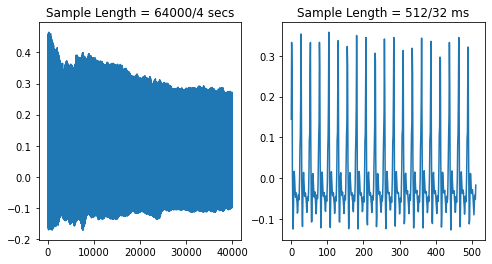

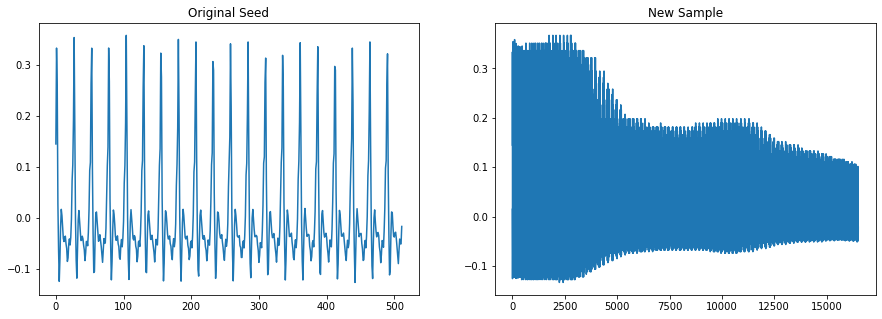

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


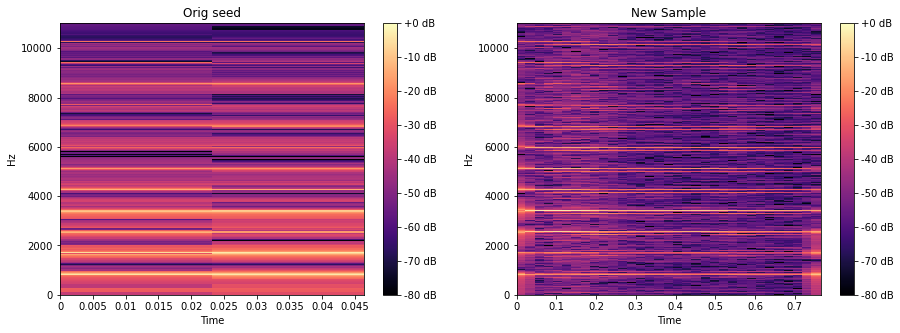

Time taken for sampling/plotting =  0:03:31


In [17]:
new_sample, orig_seed = sample_model('brass_acoustic_018-075-a.70', model=model, start_location=1, pitch=75, amplitude_scale=0.7, instrument_id=0, seq_len=16000)

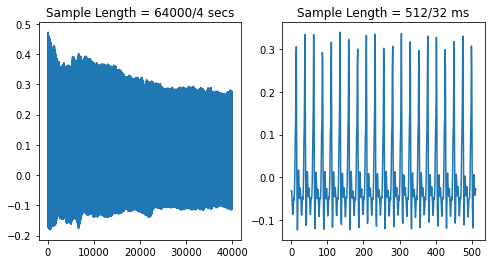

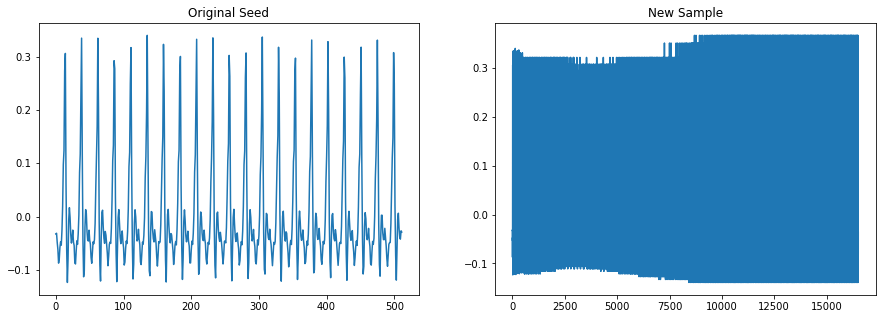

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


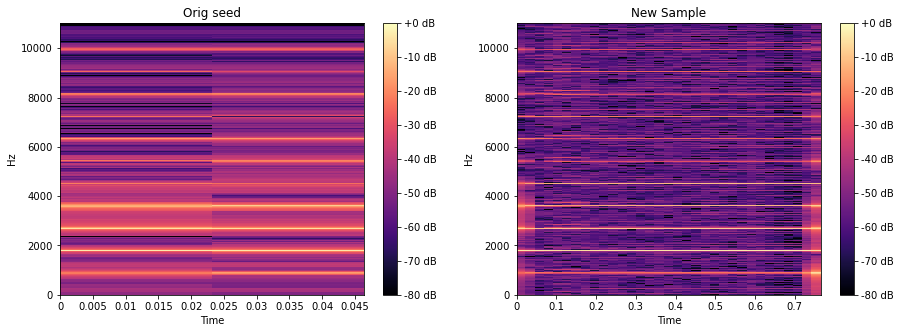

Time taken for sampling/plotting =  0:03:33


In [18]:
new_sample, orig_seed = sample_model('brass_acoustic_018-076-a.70', model=model, start_location=1, pitch=76, amplitude_scale=0.7, instrument_id=0, seq_len=16000)

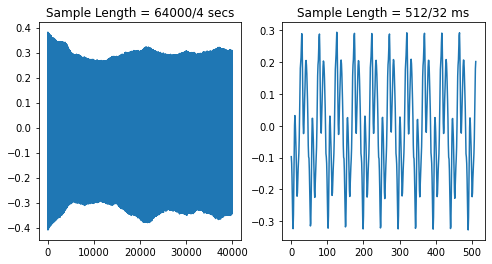

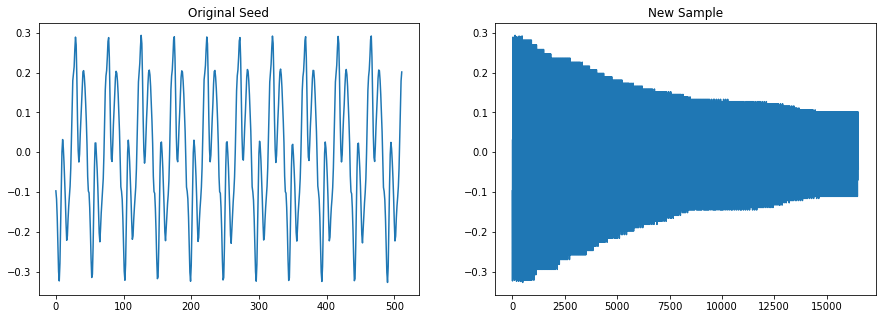

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


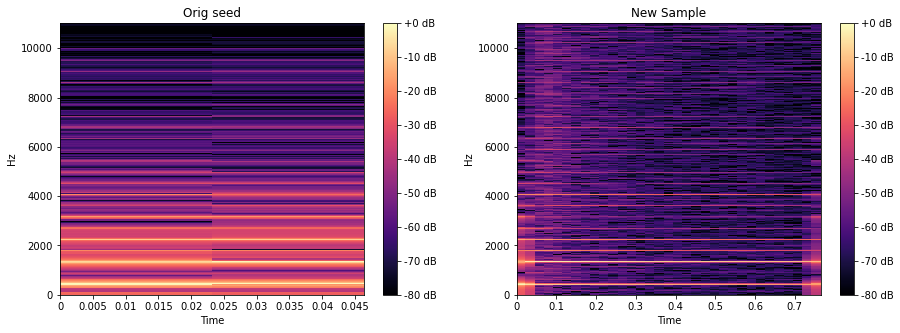

Time taken for sampling/plotting =  0:03:33


In [19]:
new_sample, orig_seed = sample_model('reed_acoustic_000-064-a.90', model=model, start_location=1, pitch=64, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

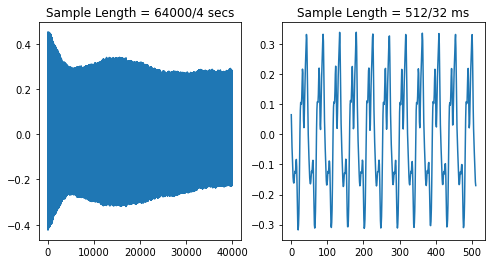

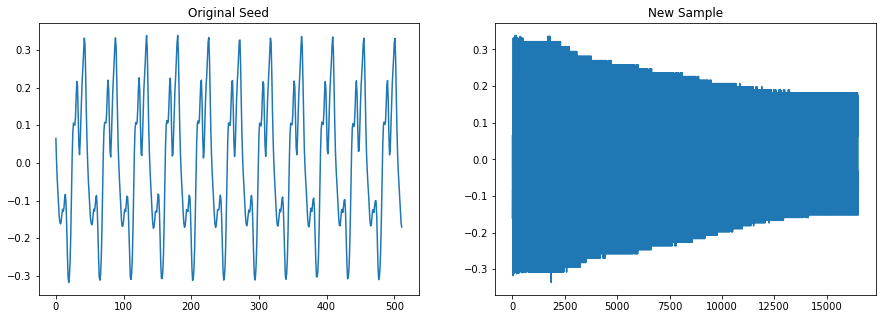

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


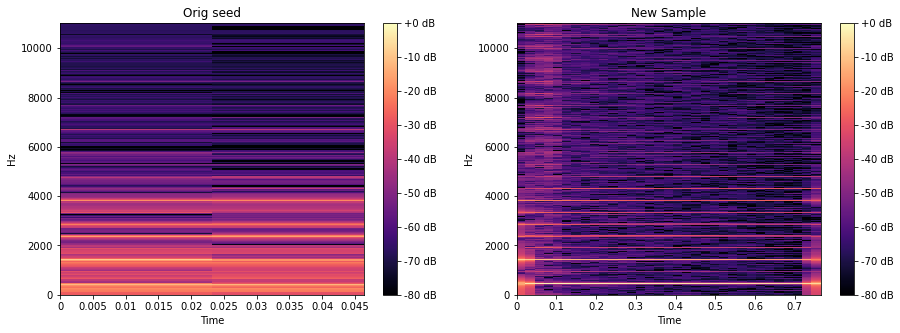

Time taken for sampling/plotting =  0:03:33


In [20]:
new_sample, orig_seed = sample_model('reed_acoustic_000-065-a.90', model=model, start_location=1, pitch=65, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

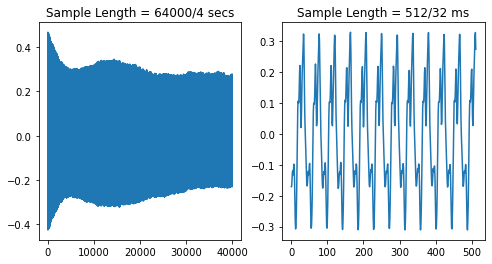

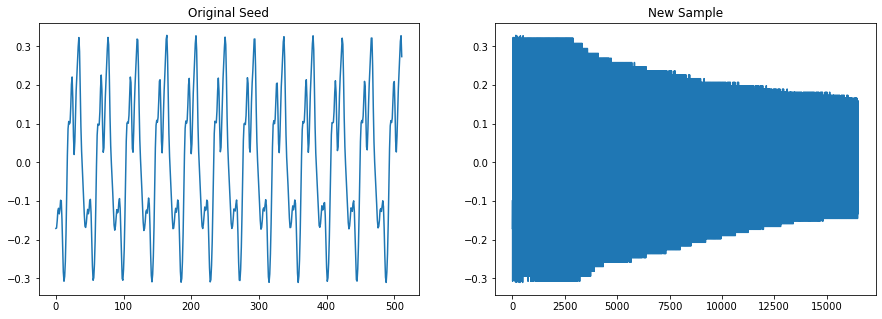

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


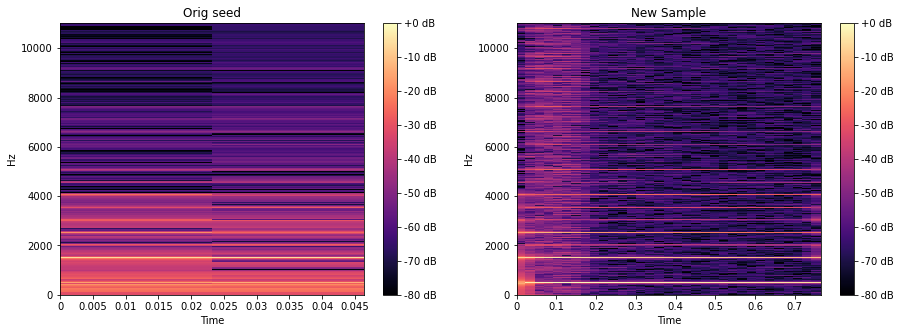

Time taken for sampling/plotting =  0:03:32


In [21]:
new_sample, orig_seed = sample_model('reed_acoustic_000-066-a.90', model=model, start_location=1, pitch=66, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

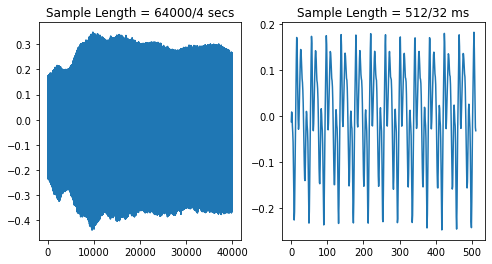

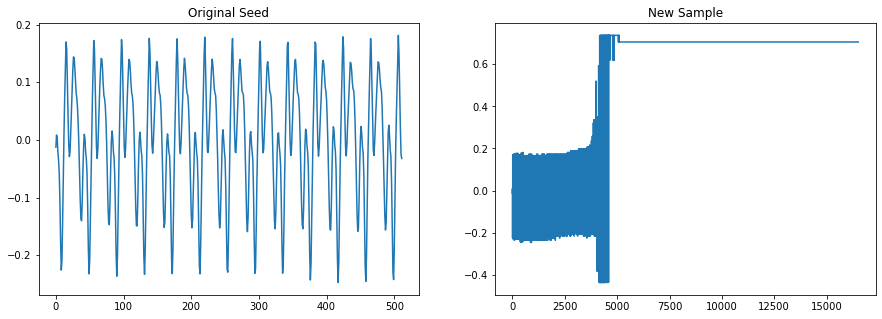

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


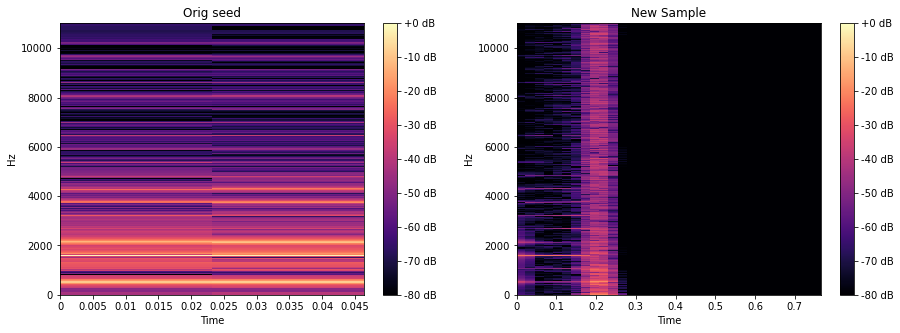

Time taken for sampling/plotting =  0:03:40


In [33]:
new_sample, orig_seed = sample_model('reed_acoustic_000-067-a.90', model=model, start_location=0, pitch=67, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

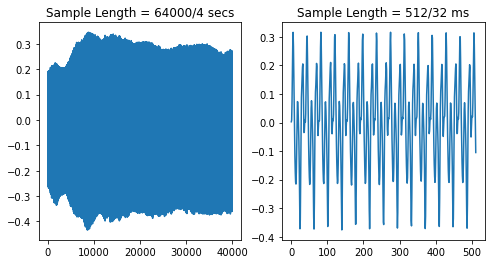

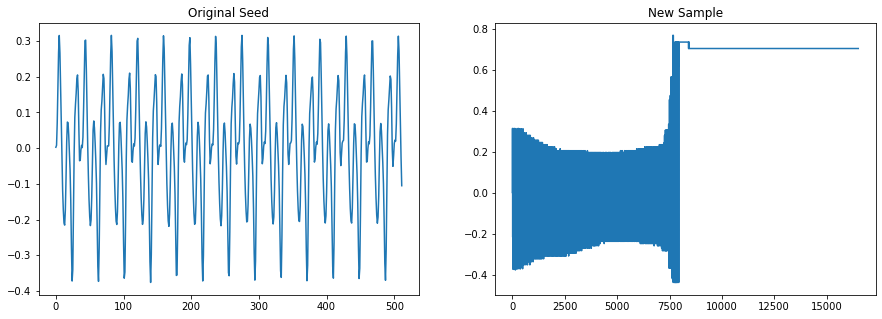

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


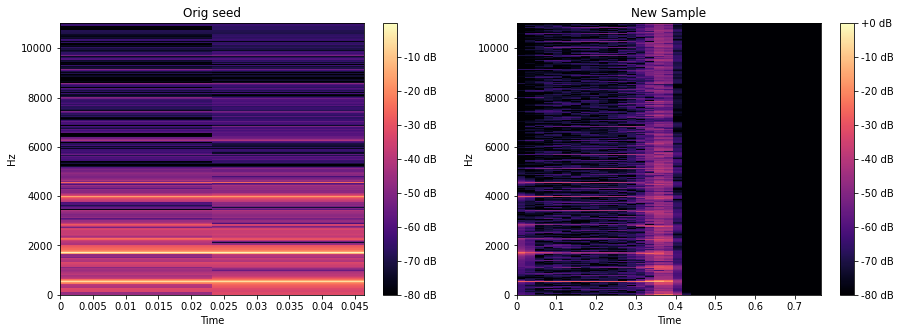

Time taken for sampling/plotting =  0:03:32


In [23]:
new_sample, orig_seed = sample_model('reed_acoustic_000-068-a.90', model=model, start_location=1, pitch=68, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

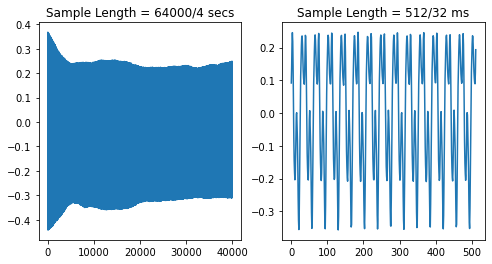

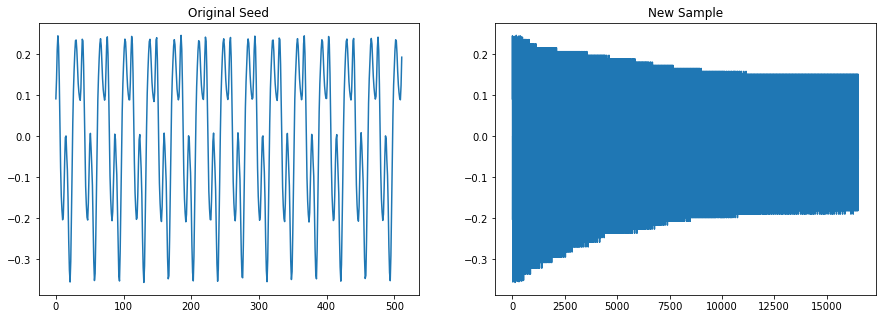

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


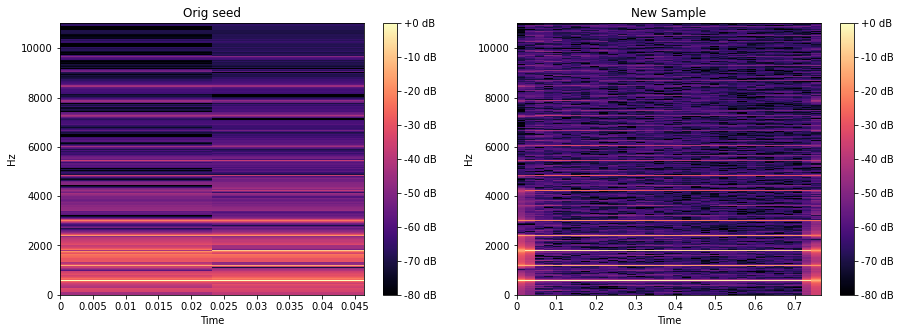

Time taken for sampling/plotting =  0:03:31


In [24]:
new_sample, orig_seed = sample_model('reed_acoustic_000-069-a.90', model=model, start_location=1, pitch=69, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

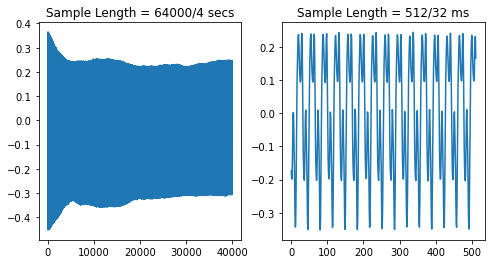

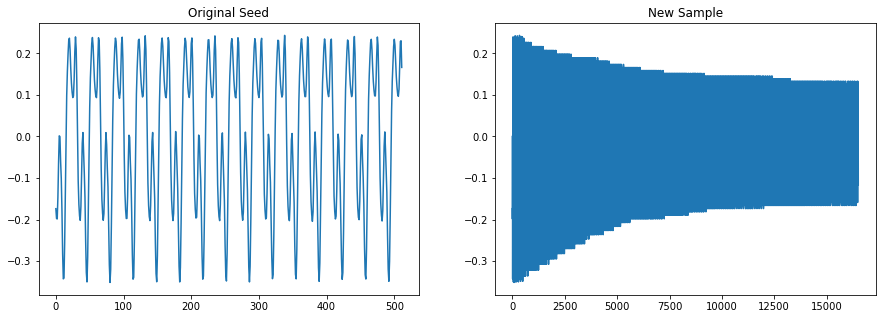

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


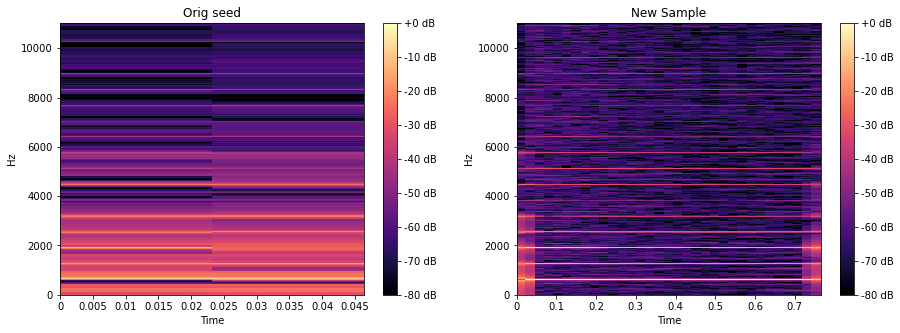

Time taken for sampling/plotting =  0:03:32


In [25]:
new_sample, orig_seed = sample_model('reed_acoustic_000-070-a.90', model=model, start_location=1, pitch=70, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

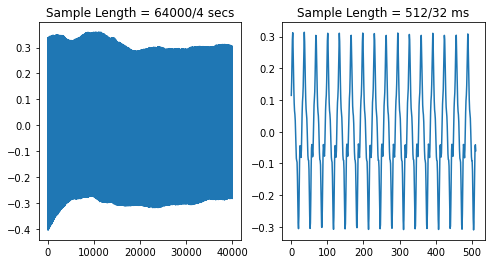

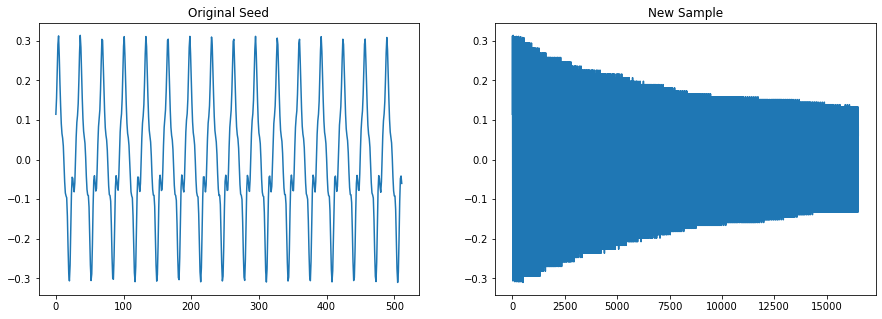

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


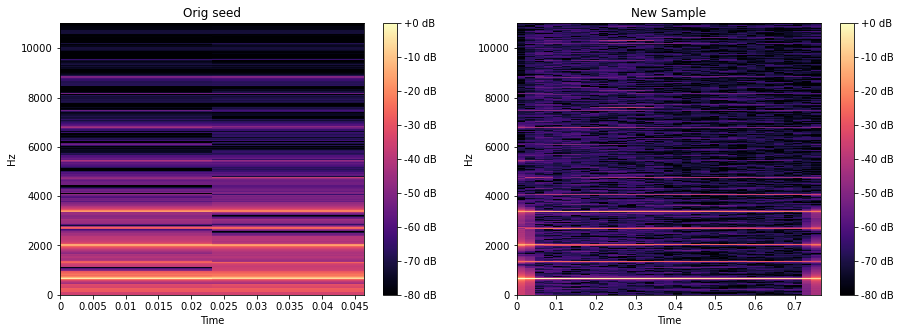

Time taken for sampling/plotting =  0:03:33


In [26]:
new_sample, orig_seed = sample_model('reed_acoustic_000-071-a.90', model=model, start_location=1, pitch=71, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

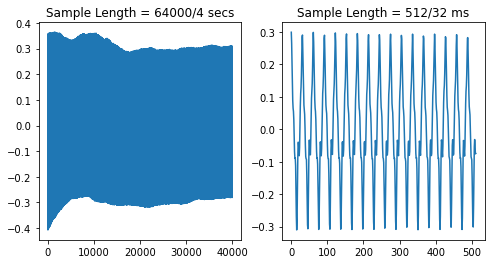

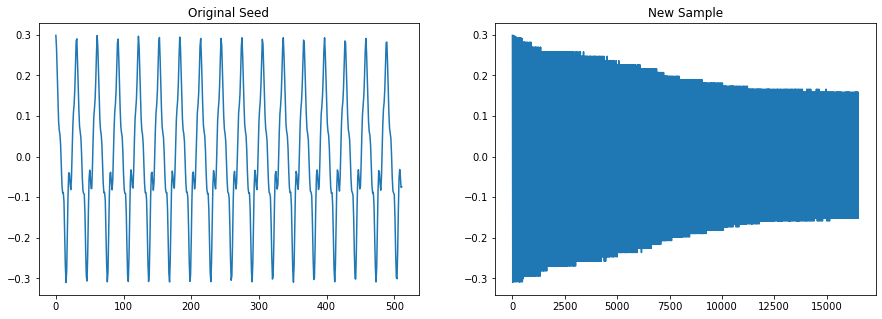

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


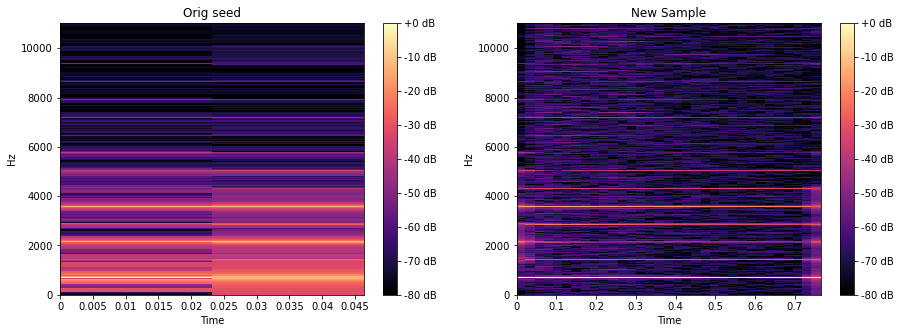

Time taken for sampling/plotting =  0:03:31


In [27]:
new_sample, orig_seed = sample_model('reed_acoustic_000-072-a.90', model=model, start_location=1, pitch=72, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

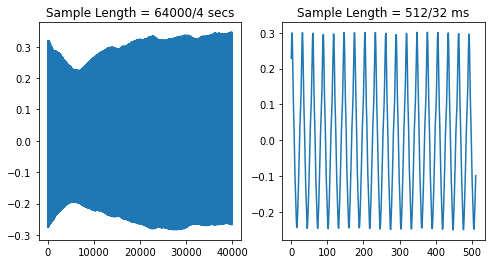

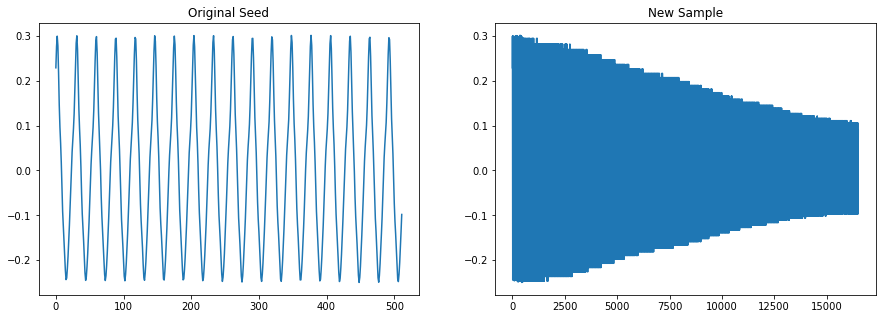

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


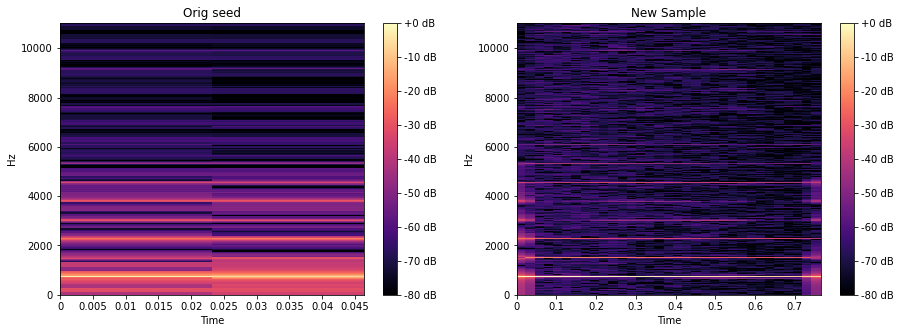

Time taken for sampling/plotting =  0:03:30


In [28]:
new_sample, orig_seed = sample_model('reed_acoustic_000-073-a.90', model=model, start_location=1, pitch=73, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

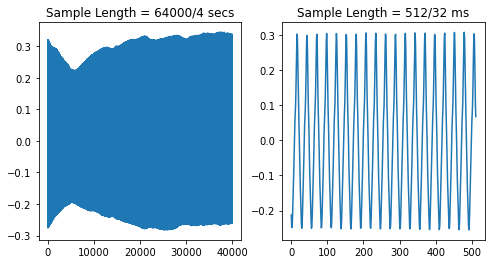

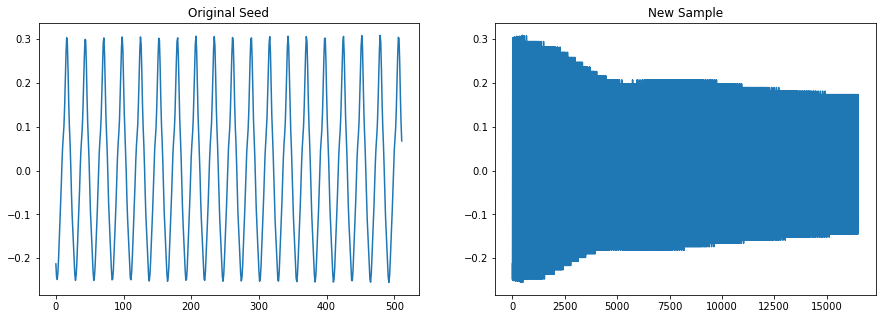

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


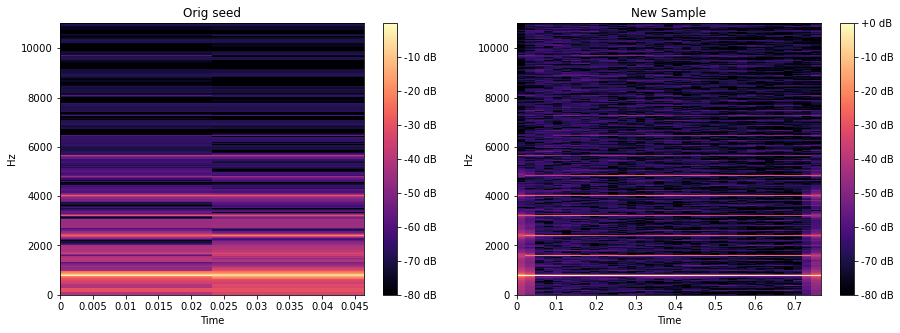

Time taken for sampling/plotting =  0:03:32


In [29]:
new_sample, orig_seed = sample_model('reed_acoustic_000-074-a.90', model=model, start_location=1, pitch=74, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

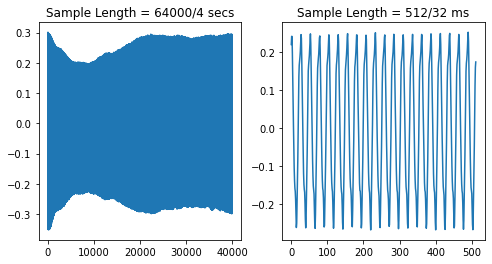

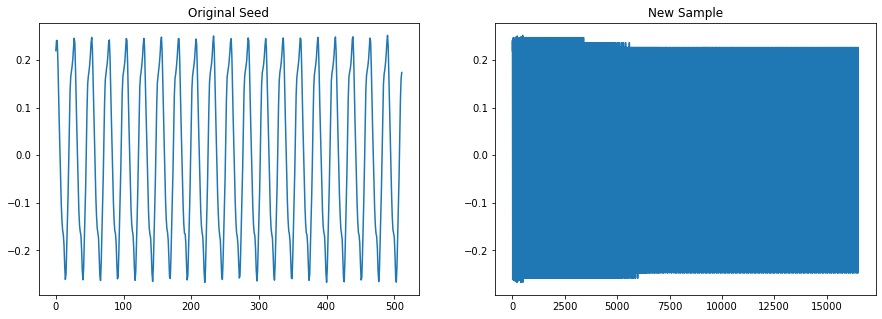

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


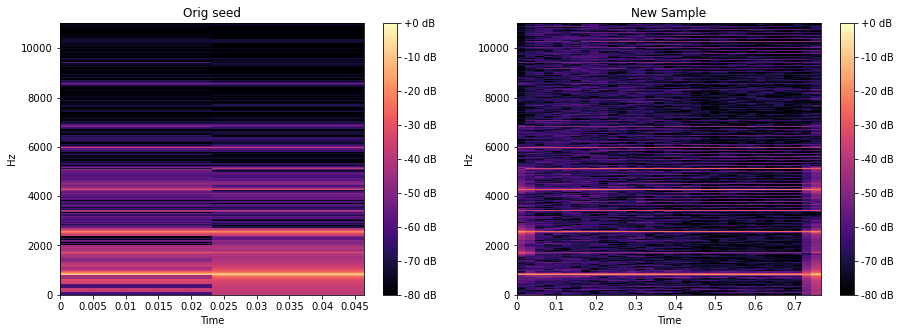

Time taken for sampling/plotting =  0:03:35


In [30]:
new_sample, orig_seed = sample_model('reed_acoustic_000-075-a.90', model=model, start_location=1, pitch=75, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

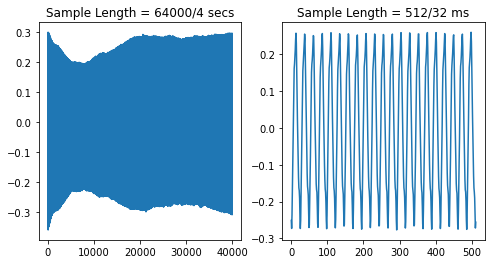

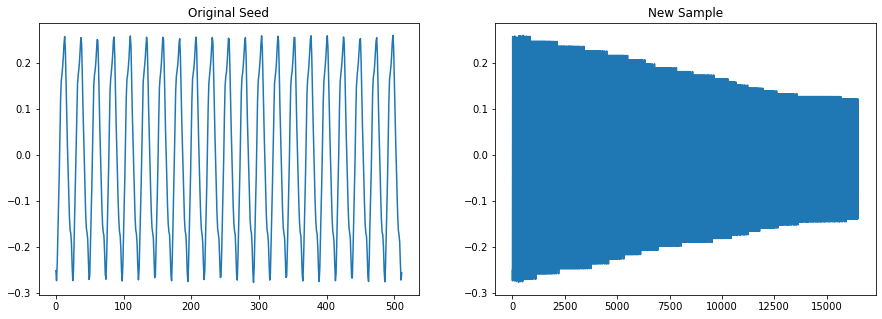

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=512
  warnings.warn(


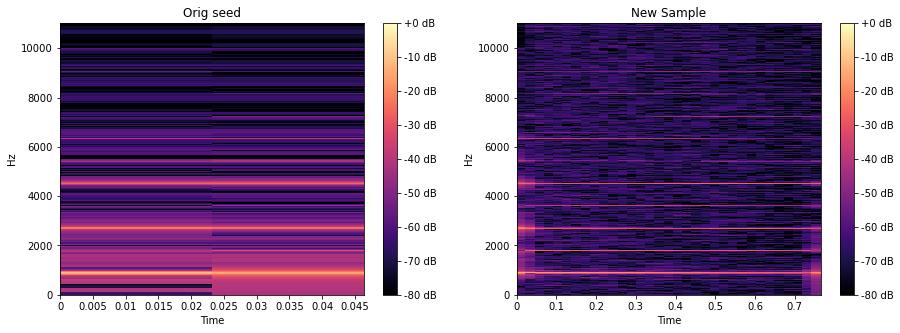

Time taken for sampling/plotting =  0:03:36


In [31]:
new_sample, orig_seed = sample_model('reed_acoustic_000-076-a.90', model=model, start_location=1, pitch=76, amplitude_scale=0.9, instrument_id=1, seq_len=16000)